In [359]:
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import vincenty
%matplotlib inline
import corner
from shapely import geometry
import seaborn as sns
from sklearn import tree
import numpy as np
from IPython.display import Image 
import pydotplus

In [76]:
synergy = pd.read_csv('synergy_effect.csv',index_col=0)

In [77]:
stops=pd.read_csv('network_setup/stop_train',index_col=0)

In [214]:
master_node = pd.read_csv('network_setup/master_node',index_col=0)
master_node= master_node.set_index('master_node_id')

In [7]:
# for i in ['station_0_lat','station_1_lat','station_0_lon','station_1_lon']:
#     del synergy[i]

In [282]:
def find_stations_within_buffer(st,dist=0.5):
    stations =-1
    st_li =[]
    point_1 = (master_node.loc[st,'stop_lat'],master_node.loc[st,'stop_lon'])
    for i in master_node.index:
        point_2 = (master_node.loc[i,'stop_lat'],master_node.loc[i,'stop_lon'])
        if vincenty(point_1,point_2).miles <=dist:
            st_li.append(i)
            stations +=1
    return stations

In [288]:
master_node['station_within_half_mile']=None
for i in master_node.index:
    master_node.loc[i,'station_within_half_mile'] = find_stations_within_buffer(i)

In [291]:
master_node.head()

,stop_name,stop_lat,stop_lon,stop_id,station_within_half_mile
master_node_id,,,,,
1 Av_0,1 Av,40.730953,-73.981628,L06,2
103 St - Corona Plaza_0,103 St - Corona Plaza,40.749865,-73.862700,706,2
103 St_0,103 St,40.799446,-73.968379,119,3
103 St_1,103 St,40.790600,-73.947478,624,3
103 St_2,103 St,40.796092,-73.961454,A18,3


In [45]:
def find_lines(master_node_id):
    """
    find which lines going through the master node
    """
    stop_id = master_node[master_node['master_node_id']==master_node_id]['stop_id'].values[0]
    stop_id= stop_id.split(',')
    lines= stops[stops['stop_id'].isin(stop_id)].train.values
    return list(lines)

In [62]:
def similarity(st_0,st_1):
    """
    calculate similarity of two master nodes
    defined as how many lines go through the master nodes in common
    """
    lines_0 = find_lines(st_0)
    lines_1 = find_lines(st_1)
    similar = 1.0*len(set(lines_0) & set(lines_1))/ len(set(lines_0+lines_1))
    return similar

In [79]:
for i in range(len(synergy)):
    st_0 = synergy.loc[i,'station_0']
    st_1 = synergy.loc[i,'station_1']
    synergy.loc[i,'similarity'] = similarity(st_0,st_1)

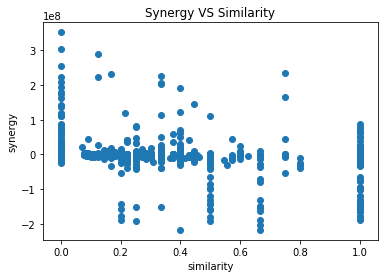

In [82]:
plt.scatter(synergy['similarity'],synergy['synergy'])
plt.xlabel('similarity')
plt.ylabel('synergy')
plt.title('Synergy VS Similarity')

(0, 151.13533137975651)

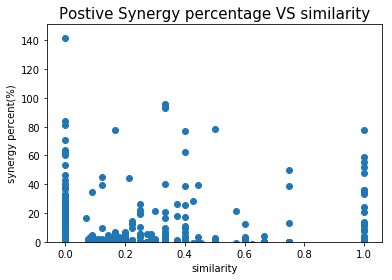

In [377]:
plt.scatter(synergy['similarity'],synergy['percent(%)'])
plt.xlabel('similarity')
plt.ylabel('synergy percent(%)')
plt.title('Postive Synergy percentage VS similarity',fontsize=15)
plt.ylim(0,)

(-60, 0)

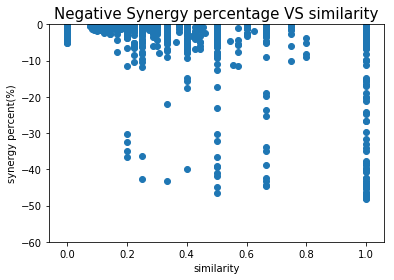

In [379]:
plt.scatter(synergy['similarity'],synergy['percent(%)'])
plt.xlabel('similarity')
plt.ylabel('synergy percent(%)')
plt.title('Negative Synergy percentage VS similarity',fontsize=15)
plt.ylim(-60,0)

In [93]:
synergy['distance']=None
for i in range(len(synergy)):
    x1 = synergy.loc[i,'station_0_lat']
    y1 = synergy.loc[i,'station_0_lon']
    x2 = synergy.loc[i,'station_1_lat']
    y2 = synergy.loc[i,'station_1_lon']
    synergy.loc[i,'distance'] = vincenty((x1,y1),(x2,y2)).miles

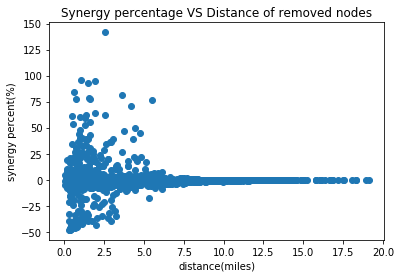

In [97]:
plt.scatter(synergy['distance'],synergy['percent(%)'])
plt.xlabel('distance(miles)')
plt.ylabel('synergy percent(%)')
plt.title('Synergy percentage VS Distance of removed nodes')

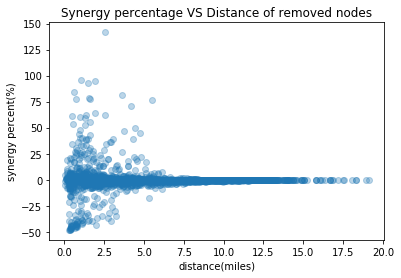

In [110]:
plt.scatter(synergy['distance'],synergy['percent(%)'],alpha=0.3)
plt.xlabel('distance(miles)')
plt.ylabel('synergy percent(%)')
plt.title('Synergy percentage VS Distance of removed nodes')
#plt.ylim(-60,0)

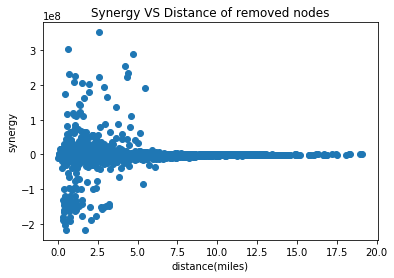

In [98]:
plt.scatter(synergy['distance'],synergy['synergy'])
plt.xlabel('distance(miles)')
plt.ylabel('synergy')
plt.title('Synergy VS Distance of removed nodes')

In [119]:
degree = pd.read_csv('new_defined_degree_centrality.csv',index_col=0)

In [126]:
synergy = synergy.merge(degree.rename(columns={'0':'station_0','1':'degree_0'}),
              on = 'station_0')
synergy = synergy.merge(degree.rename(columns={'0':'station_1','1':'degree_1'}),
              on = 'station_1')

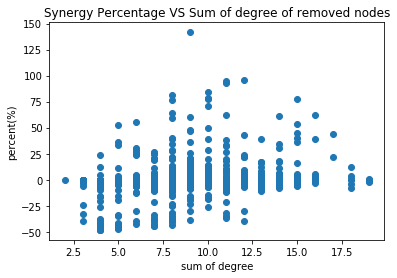

In [131]:
plt.scatter(synergy['degree_0']+synergy['degree_1'],synergy['percent(%)'])
plt.xlabel('sum of degree')
plt.ylabel('percent(%)')
plt.title('Synergy Percentage VS Sum of degree of removed nodes')

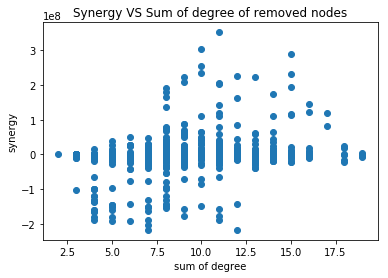

In [132]:
plt.scatter(synergy['degree_0']+synergy['degree_1'],synergy['synergy'])
plt.xlabel('sum of degree')
plt.ylabel('synergy')
plt.title('Synergy VS Sum of degree of removed nodes')

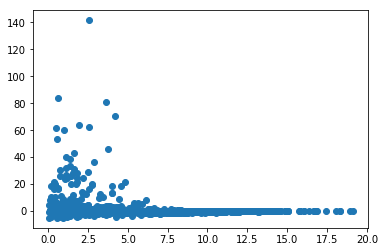

In [116]:
plt.scatter(synergy[synergy['similarity']==0]['distance'],synergy[synergy['similarity']==0]['percent(%)'])

In [145]:
synergy.head(2)

,delay,station_0,station_1,delay_0,delay_1,sum,synergy,station_0_lat,station_0_lon,station_1_lat,station_1_lon,percent(%),similarity,distance,degree_0,degree_1
0,9.312560e+08,Jackson Hts - Roosevelt Av_0,Broadway Jct_0,3.159173e+08,3.264058e+08,6.423231e+08,2.889329e+08,40.746644,-73.891338,40.678904,-73.904579,44.982494,0.125,4.72563,6,9
1,5.894977e+08,149 St - Grand Concourse_0,Broadway Jct_0,2.644819e+08,3.264058e+08,5.908877e+08,-1.390047e+06,40.818398,-73.926929,40.678904,-73.904579,-0.235247,0.000,9.69668,4,9


In [151]:
whole_network_duration = pd.read_csv('whole_network_duration_shortest_path.csv',index_col=0)

In [152]:
del whole_network_duration['shortest_path']

In [153]:
whole_network_duration= whole_network_duration.rename(columns={'from_master':'station_0', 
                                                               'to_master':'station_1',
                                                               'duration':"network_distance"})

In [156]:
synergy = synergy.merge(whole_network_duration,on=['station_0','station_1'],how='left')

In [158]:
synergy =synergy.rename(columns={'distance':'geo_distance'})

In [160]:
synergy.head()

,delay,station_0,station_1,delay_0,delay_1,sum,synergy,station_0_lat,station_0_lon,station_1_lat,station_1_lon,percent(%),similarity,geo_distance,degree_0,degree_1,network_distance
0,9.312560e+08,Jackson Hts - Roosevelt Av_0,Broadway Jct_0,3.159173e+08,3.264058e+08,6.423231e+08,2.889329e+08,40.746644,-73.891338,40.678904,-73.904579,44.982494,0.125,4.72563,6,9,2435.945946
1,5.894977e+08,149 St - Grand Concourse_0,Broadway Jct_0,2.644819e+08,3.264058e+08,5.908877e+08,-1.390047e+06,40.818398,-73.926929,40.678904,-73.904579,-0.235247,0.000,9.69668,4,9,3063.694030
2,5.794607e+08,125 St_2,Broadway Jct_0,2.562949e+08,3.264058e+08,5.827007e+08,-3.240040e+06,40.804138,-73.937594,40.678904,-73.904579,-0.556038,0.000,8.81347,4,9,2761.323529
3,4.464882e+08,Newkirk Plaza_0,Broadway Jct_0,1.237503e+08,3.264058e+08,4.501560e+08,-3.667820e+06,40.635082,-73.962793,40.678904,-73.904579,-0.814789,0.000,4.30132,4,9,1795.408163
4,4.283320e+08,Essex St_0,Broadway Jct_0,3.881425e+07,3.264058e+08,3.652200e+08,6.311200e+07,40.718315,-73.987437,40.678904,-73.904579,17.280542,0.400,5.13129,4,9,1407.692308


In [196]:
synergy.to_csv('explore_synergy_explanation.csv')

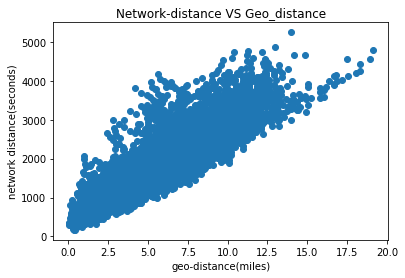

In [168]:
plt.scatter(synergy['geo_distance'],synergy['network_distance'])
plt.xlabel('geo-distance(miles)')
plt.ylabel('network distance(seconds)')
plt.title('Network-distance VS Geo_distance')

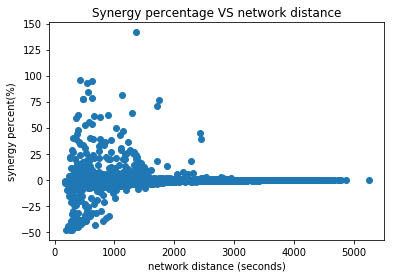

In [169]:
plt.scatter(synergy['network_distance'],synergy['percent(%)'])
plt.xlabel('network distance (seconds)')
plt.ylabel('synergy percent(%)')
plt.title('Synergy percentage VS network distance')

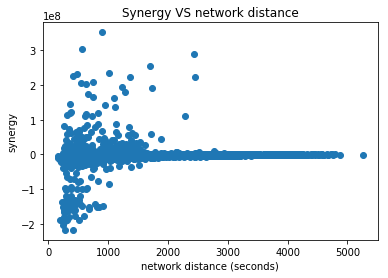

In [170]:
plt.scatter(synergy['network_distance'],synergy['synergy'])
plt.xlabel('network distance (seconds)')
plt.ylabel('synergy')
plt.title('Synergy VS network distance')

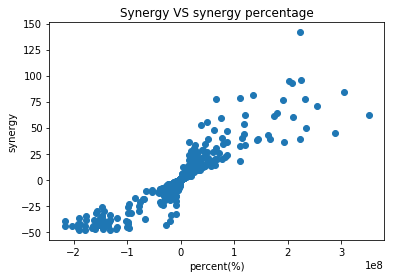

In [200]:
plt.scatter(synergy['synergy'],synergy['percent(%)'])
plt.xlabel('percent(%)')
plt.ylabel('synergy')
plt.title('Synergy VS synergy percentage')

/gpfs1/cusp/ys2808/.conda/envs/JupyterVE/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


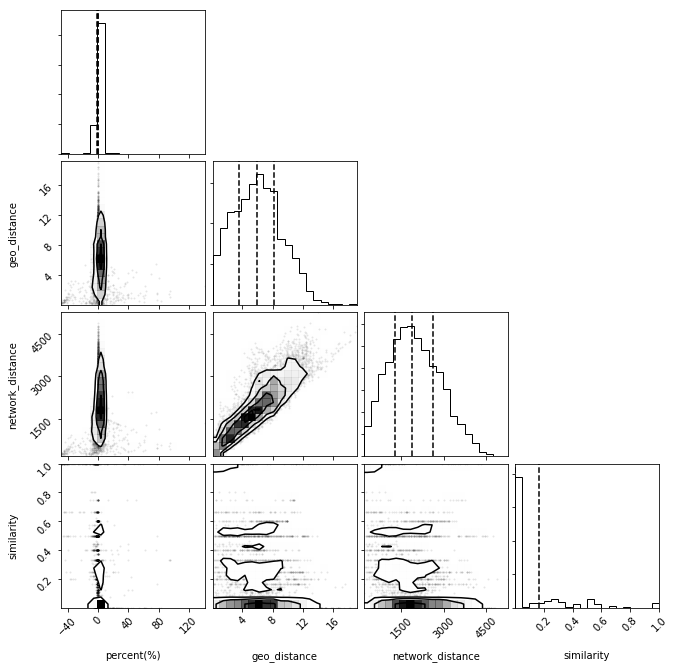

In [197]:
data = synergy[['percent(%)','geo_distance','network_distance','similarity']]
data['geo_distance']=map(float,data['geo_distance'])
figure = corner.corner(data,quantiles=[0.25, 0.5, 0.75])

/gpfs1/cusp/ys2808/.conda/envs/JupyterVE/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


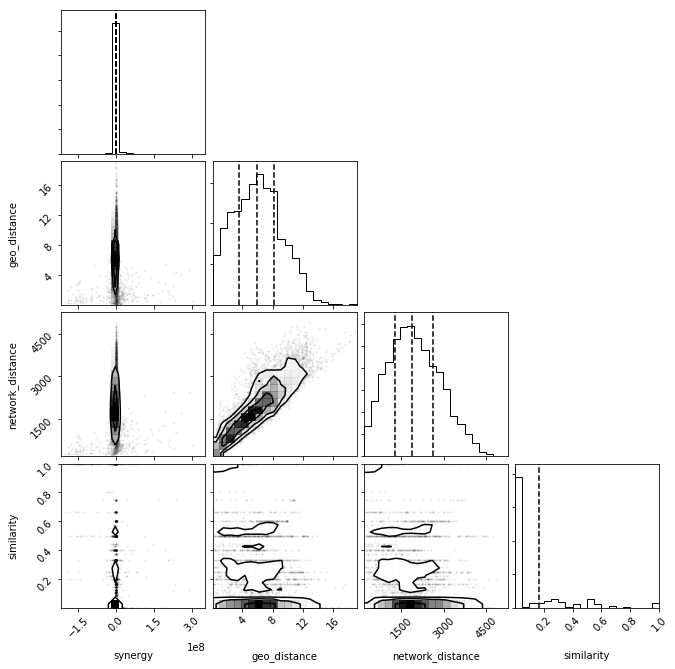

In [198]:
data = synergy[['synergy','geo_distance','network_distance','similarity']]
data['geo_distance']=map(float,data['geo_distance'])
figure = corner.corner(data,quantiles=[0.25, 0.5, 0.75])

In [295]:
master_node= master_node.reset_index()

In [300]:
synergy = synergy.merge(master_node.rename(columns={'master_node_id':'station_0',
                           'station_within_half_mile':'stations_in_buffer_0'})[['station_0',
                                                                                'stations_in_buffer_0']],
             on='station_0')

synergy = synergy.merge(master_node.rename(columns={'master_node_id':'station_1',
                           'station_within_half_mile':'stations_in_buffer_1'})[['station_1',
                                                                                'stations_in_buffer_1']],
             on='station_1')

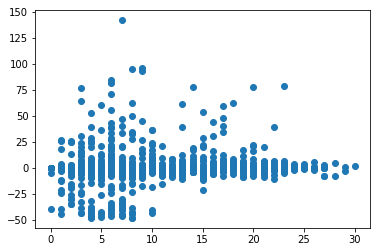

In [302]:
plt.scatter(synergy['stations_in_buffer_0']+synergy['stations_in_buffer_1'],synergy['percent(%)'])

In [301]:
synergy.head()

,delay,station_0,station_1,delay_0,delay_1,sum,synergy,station_0_lat,station_0_lon,station_1_lat,station_1_lon,percent(%),similarity,geo_distance,degree_0,degree_1,network_distance,stations_in_buffer_0,stations_in_buffer_1
0,9.312560e+08,Jackson Hts - Roosevelt Av_0,Broadway Jct_0,3.159173e+08,3.264058e+08,6.423231e+08,2.889329e+08,40.746644,-73.891338,40.678904,-73.904579,44.982494,0.125,4.72563,6,9,2435.945946,4,5
1,5.894977e+08,149 St - Grand Concourse_0,Broadway Jct_0,2.644819e+08,3.264058e+08,5.908877e+08,-1.390047e+06,40.818398,-73.926929,40.678904,-73.904579,-0.235247,0.000,9.69668,4,9,3063.694030,1,5
2,5.794607e+08,125 St_2,Broadway Jct_0,2.562949e+08,3.264058e+08,5.827007e+08,-3.240040e+06,40.804138,-73.937594,40.678904,-73.904579,-0.556038,0.000,8.81347,4,9,2761.323529,2,5
3,4.464882e+08,Newkirk Plaza_0,Broadway Jct_0,1.237503e+08,3.264058e+08,4.501560e+08,-3.667820e+06,40.635082,-73.962793,40.678904,-73.904579,-0.814789,0.000,4.30132,4,9,1795.408163,2,5
4,4.283320e+08,Essex St_0,Broadway Jct_0,3.881425e+07,3.264058e+08,3.652200e+08,6.311200e+07,40.718315,-73.987437,40.678904,-73.904579,17.280542,0.400,5.13129,4,9,1407.692308,5,5


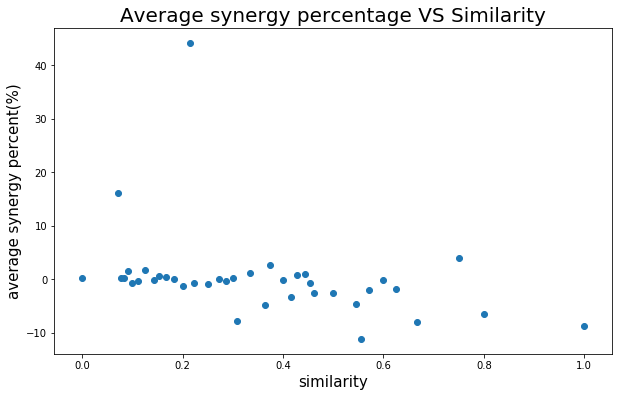

In [326]:
plt.figure(figsize=(10,6))
plt.scatter(synergy.groupby('similarity').mean()['percent(%)'].index,
            synergy.groupby('similarity').mean()['percent(%)'])
plt.xlabel('similarity',fontsize=15)
plt.ylabel('average synergy percent(%)',fontsize=15)
plt.title('Average synergy percentage VS Similarity', fontsize=20)